# Лабораторная работа: Детектор аномалий на базе сверточного автокодировщика

---

**Студент:** Коба Алексей Юрьевич  
**Группа:** 5130904/20101  
**Дата:** 21 октября 2025 г.

---

## 📋 Цель работы

Построить **сверточный автокодировщик** для детекции аномалий:
- Обучить модель на датасете рукописных цифр **MNIST**
- Использовать изображения из **Fashion-MNIST** в качестве аномалий
- При подаче аномального изображения система должна выдавать сообщение: **"Изображение не содержит рукописной цифры"**

---

## 1️) Импорт библиотек и настройка параметров

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print('TensorFlow version:', tf.__version__)
print('GPU доступен:', 'Да' if tf.config.list_physical_devices('GPU') else 'Нет')

np.random.seed(42)
tf.random.set_seed(42)
print('Random seed установлен: 42')

✅ TensorFlow version: 2.10.0
✅ GPU доступен: Да
✅ Random seed установлен: 42


In [26]:
# ПАРАМЕТРЫ МОДЕЛИ (УЛУЧШЕННЫЕ)

IMG_SHAPE = (28, 28, 1)      # Размер изображения
BATCH_SIZE = 128             # Размер батча
EPOCHS = 25                  # Количество эпох 
LATENT_DIM = 64              # Размерность латентного пространства 

print('Параметры модели:')
print(f'   Размер изображения: {IMG_SHAPE}')
print(f'   Batch size: {BATCH_SIZE}')
print(f'   Количество эпох: {EPOCHS}')
print(f'   Латентная размерность: {LATENT_DIM}')

Параметры модели:
   Размер изображения: (28, 28, 1)
   Batch size: 128
   Количество эпох: 25
   Латентная размерность: 64


---
## 2️) Загрузка и подготовка данных

In [27]:
from tensorflow.keras.datasets import mnist, fashion_mnist

(x_train_mnist, _), (x_test_mnist, _) = mnist.load_data()
(f_train_fashion, _), (f_test_fashion, _) = fashion_mnist.load_data()

# Объединение train и test для последующего разделения
x_all = np.concatenate([x_train_mnist, x_test_mnist], axis=0)
f_all = np.concatenate([f_train_fashion, f_test_fashion], axis=0)

print(f'MNIST загружен: {x_all.shape}')
print(f'Fashion-MNIST загружен: {f_all.shape}')

MNIST загружен: (70000, 28, 28)
Fashion-MNIST загружен: (70000, 28, 28)


In [28]:
# Нормализация в диапазон [0, 1]
x_all = x_all.astype('float32') / 255.0
f_all = f_all.astype('float32') / 255.0

# Добавление канального измерения (28, 28) -> (28, 28, 1)
x_all = np.expand_dims(x_all, -1)
f_all = np.expand_dims(f_all, -1)

# Разделение MNIST: 80% train, 10% validation, 10% test
train_size = int(0.8 * len(x_all))
val_size = int(0.1 * len(x_all))

x_train = x_all[:train_size]
x_val = x_all[train_size:train_size+val_size]
x_test = x_all[train_size+val_size:]

# Разделение Fashion-MNIST: 50% для оптимизации порога, 50% для теста
f_val = f_all[:len(f_all)//2]
f_test = f_all[len(f_all)//2:]

print('\nРазмеры датасетов после разделения:')
print(f'   MNIST train:      {x_train.shape}')
print(f'   MNIST validation: {x_val.shape}')
print(f'   MNIST test:       {x_test.shape}')
print(f'   Fashion validation: {f_val.shape}')
print(f'   Fashion test:       {f_test.shape}')


Размеры датасетов после разделения:
   MNIST train:      (56000, 28, 28, 1)
   MNIST validation: (7000, 28, 28, 1)
   MNIST test:       (7000, 28, 28, 1)
   Fashion validation: (35000, 28, 28, 1)
   Fashion test:       (35000, 28, 28, 1)


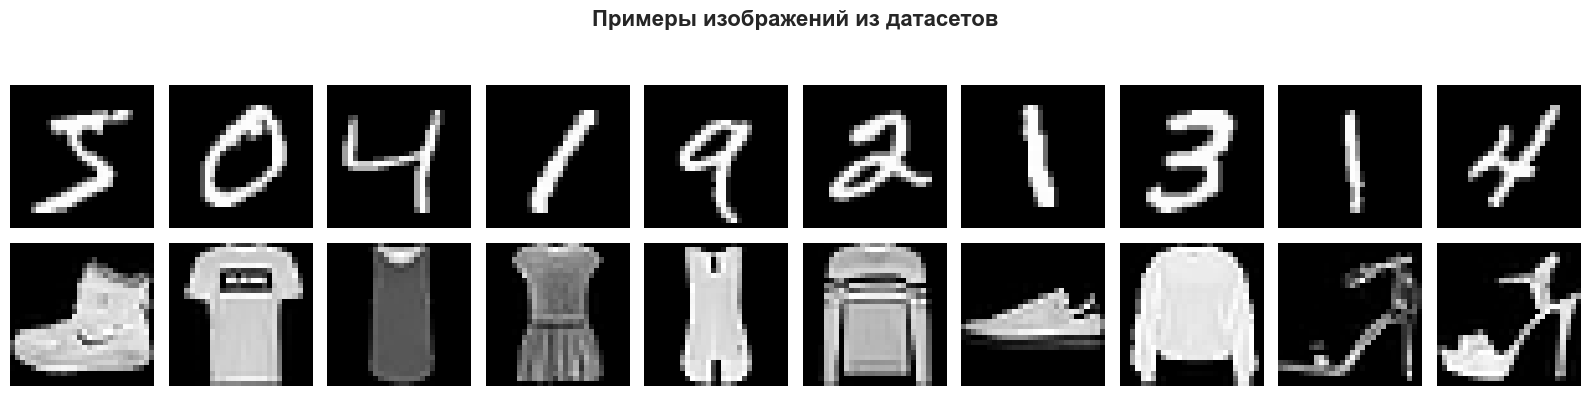

In [29]:
# Визуализация примеров из датасетов
fig, axes = plt.subplots(2, 10, figsize=(16, 4))
fig.suptitle('Примеры изображений из датасетов', fontsize=16, fontweight='bold', y=1.02)

# MNIST
for i in range(10):
    axes[0, i].imshow(x_train[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
axes[0, 0].set_ylabel('MNIST\n(Normal)', fontsize=12, fontweight='bold')

# Fashion-MNIST
for i in range(10):
    axes[1, i].imshow(f_all[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
axes[1, 0].set_ylabel('Fashion-MNIST\n(Anomaly)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 3️) Построение архитектуры автокодировщика

In [30]:
def build_improved_autoencoder(input_shape=IMG_SHAPE, latent_dim=LATENT_DIM):
    # ========== ENCODER ==========
    inp = layers.Input(shape=input_shape, name='input')
    
    # Блок 1: 28x28 -> 14x14
    x = layers.Conv2D(32, 3, padding='same', 
                      kernel_regularizer=regularizers.l2(1e-5))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)
    
    # Блок 2: 14x14 -> 7x7
    x = layers.Conv2D(64, 3, padding='same',
                      kernel_regularizer=regularizers.l2(1e-5))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)
    
    # Блок 3: 7x7
    x = layers.Conv2D(128, 3, padding='same',
                      kernel_regularizer=regularizers.l2(1e-5))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Латентное пространство
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='relu', 
                          name='latent_space',
                          kernel_regularizer=regularizers.l2(1e-5))(x)
    
    # ========== DECODER ==========
    x = layers.Dense(7*7*128, activation='relu')(latent)
    x = layers.Reshape((7, 7, 128))(x)
    
    # Блок декодирования 1: 7x7 -> 7x7
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Блок декодирования 2: 7x7 -> 14x14
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Блок декодирования 3: 14x14 -> 28x28
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Выходной слой
    output = layers.Conv2D(1, 3, activation='sigmoid', 
                          padding='same', name='output')(x)
    
    model = models.Model(inputs=inp, outputs=output, 
                        name='improved_conv_autoencoder')
    return model

In [31]:
# Создание и компиляция модели
autoencoder = build_improved_autoencoder()

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print('Архитектура модели построена\n')
autoencoder.summary()

Архитектура модели построена

Model: "improved_conv_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (

---
## 4️) Обучение модели

Используемые callbacks:
- **EarlyStopping**: останавливает обучение при отсутствии улучшений (patience=7)
- **ModelCheckpoint**: сохраняет лучшую модель по метрике val_loss
- **ReduceLROnPlateau**: адаптивно уменьшает learning rate при плато (factor=0.5, patience=3)

In [32]:
import tempfile

# Путь для сохранения лучшей модели
ckpt_path = os.path.join(tempfile.gettempdir(), 'improved_ae_mnist.h5')

# Настройка callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        ckpt_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

In [33]:
# Обучение модели
history = autoencoder.fit(
    x_train, x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_val, x_val),
    callbacks=callbacks,
    verbose=1
)

print(f'\nОбучение завершено!')
print(f'Лучшая модель сохранена: {ckpt_path}')

# Загрузка лучших весов
autoencoder.load_weights(ckpt_path)
print('Веса лучшей модели загружены')

Epoch 1/25
437/438 [============================>.] - ETA: 0s - loss: 0.0182 - mae: 0.0572
Epoch 1: val_loss improved from inf to 0.02017, saving model to C:\Users\alexy\AppData\Local\Temp\improved_ae_mnist.h5
438/438 [==============================] - 10s 21ms/step - loss: 0.0181 - mae: 0.0572 - val_loss: 0.0202 - val_mae: 0.0535 - lr: 0.0010
Epoch 2/25
436/438 [============================>.] - ETA: 0s - loss: 0.0067 - mae: 0.0267
Epoch 2: val_loss improved from 0.02017 to 0.00611, saving model to C:\Users\alexy\AppData\Local\Temp\improved_ae_mnist.h5
438/438 [==============================] - 9s 20ms/step - loss: 0.0067 - mae: 0.0267 - val_loss: 0.0061 - val_mae: 0.0248 - lr: 0.0010
Epoch 3/25
436/438 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0230
Epoch 3: val_loss improved from 0.00611 to 0.00503, saving model to C:\Users\alexy\AppData\Local\Temp\improved_ae_mnist.h5
438/438 [==============================] - 9s 20ms/step - loss: 0.0053 - mae: 0.0230 - val_

---
## 5️) Визуализация процесса обучения

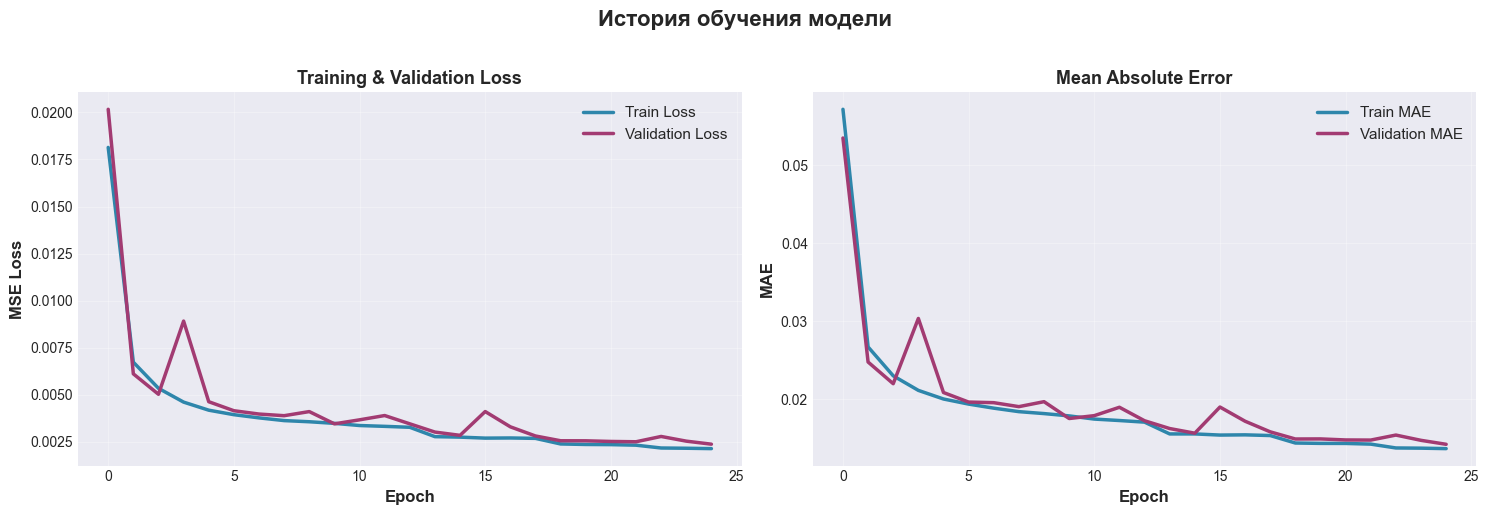


Финальные метрики обучения:
   Train Loss: 0.002142
   Val Loss:   0.002377
   Train MAE:  0.013693
   Val MAE:    0.014246


In [34]:
# График истории обучения
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('История обучения модели', fontsize=16, fontweight='bold', y=1.02)

# График Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2.5, color='#2E86AB')
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5, color='#A23B72')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('MSE Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training & Validation Loss', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# График MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2.5, color='#2E86AB')
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2.5, color='#A23B72')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Вывод финальных метрик
print(f'\nФинальные метрики обучения:')
print(f'   Train Loss: {history.history["loss"][-1]:.6f}')
print(f'   Val Loss:   {history.history["val_loss"][-1]:.6f}')
print(f'   Train MAE:  {history.history["mae"][-1]:.6f}')
print(f'   Val MAE:    {history.history["val_mae"][-1]:.6f}')

---
## 6️) ROC-оптимизация порога детекции

Используем **ROC-анализ** для определения оптимального порога:
- Вычисляем ошибки реконструкции для MNIST (нормальные) и Fashion-MNIST (аномалии)
- Строим ROC-кривую
- Находим порог, максимизирующий **(TPR - FPR)**

In [35]:
def compute_reconstruction_errors(model, images, batch_size=256):
    reconstructed = model.predict(images, batch_size=batch_size, verbose=0)
    mse_errors = np.mean((images - reconstructed)**2, axis=(1, 2, 3))
    return mse_errors

print('Вычисление ошибок реконструкции на валидационных данных...')

errors_mnist_val = compute_reconstruction_errors(autoencoder, x_val)
errors_fashion_val = compute_reconstruction_errors(autoencoder, f_val)

print(f'MNIST validation errors: mean={errors_mnist_val.mean():.6f}, std={errors_mnist_val.std():.6f}')
print(f'Fashion validation errors: mean={errors_fashion_val.mean():.6f}, std={errors_fashion_val.std():.6f}')

Вычисление ошибок реконструкции на валидационных данных...
MNIST validation errors: mean=0.002182, std=0.001427
Fashion validation errors: mean=0.076998, std=0.040264


In [36]:
# ROC-анализ для определения оптимального порога
print('\nROC-анализ для оптимизации порога...\n')

# Метки: 0 = нормальные (MNIST), 1 = аномалии (Fashion)
y_true = np.concatenate([
    np.zeros(len(errors_mnist_val)),
    np.ones(len(errors_fashion_val))
])

y_scores = np.concatenate([errors_mnist_val, errors_fashion_val])

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Оптимальный порог: максимизируем (TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('='*70)
print('РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ ПОРОГА')
print('='*70)
print(f'   ROC-AUC Score:       {roc_auc:.4f}')
print(f'   Оптимальный порог:   {optimal_threshold:.6f}')
print(f'   TPR (True Positive Rate):  {tpr[optimal_idx]:.4f} ({tpr[optimal_idx]*100:.2f}%)')
print(f'   FPR (False Positive Rate): {fpr[optimal_idx]:.4f} ({fpr[optimal_idx]*100:.2f}%)')
print(f'   Youden Index (TPR-FPR):    {(tpr[optimal_idx]-fpr[optimal_idx]):.4f}')
print('='*70)


ROC-анализ для оптимизации порога...

РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ ПОРОГА
   ROC-AUC Score:       0.9999
   Оптимальный порог:   0.008729
   TPR (True Positive Rate):  0.9975 (99.75%)
   FPR (False Positive Rate): 0.0036 (0.36%)
   Youden Index (TPR-FPR):    0.9939


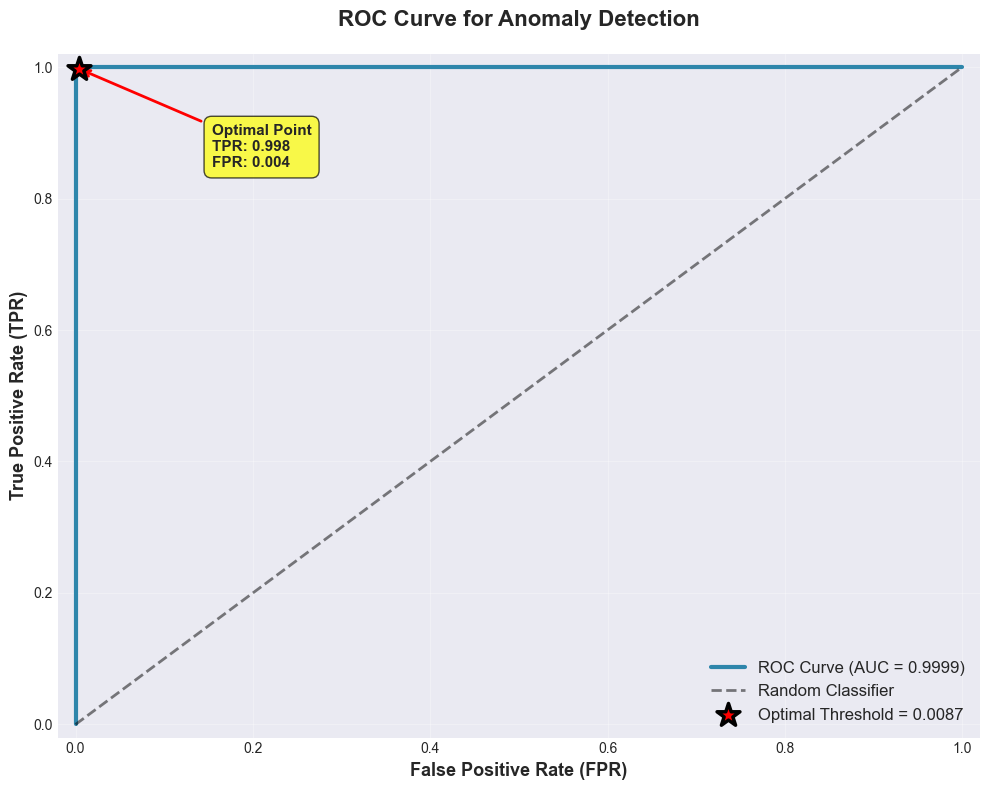

In [37]:
# Визуализация ROC-кривой
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, linewidth=3, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='#2E86AB')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier', alpha=0.5)

# Отметка оптимального порога
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], s=300, c='red', 
           marker='*', edgecolors='black', linewidths=2.5,
           label=f'Optimal Threshold = {optimal_threshold:.4f}', zorder=5)

plt.xlabel('False Positive Rate (FPR)', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=13, fontweight='bold')
plt.title('ROC Curve for Anomaly Detection', fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])

plt.annotate(f'Optimal Point\nTPR: {tpr[optimal_idx]:.3f}\nFPR: {fpr[optimal_idx]:.3f}',
            xy=(fpr[optimal_idx], tpr[optimal_idx]), 
            xytext=(fpr[optimal_idx]+0.15, tpr[optimal_idx]-0.15),
            fontsize=11, fontweight='bold',
            arrowprops=dict(arrowstyle='->', lw=2, color='red'),
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 7️) Визуализация распределений ошибок реконструкции

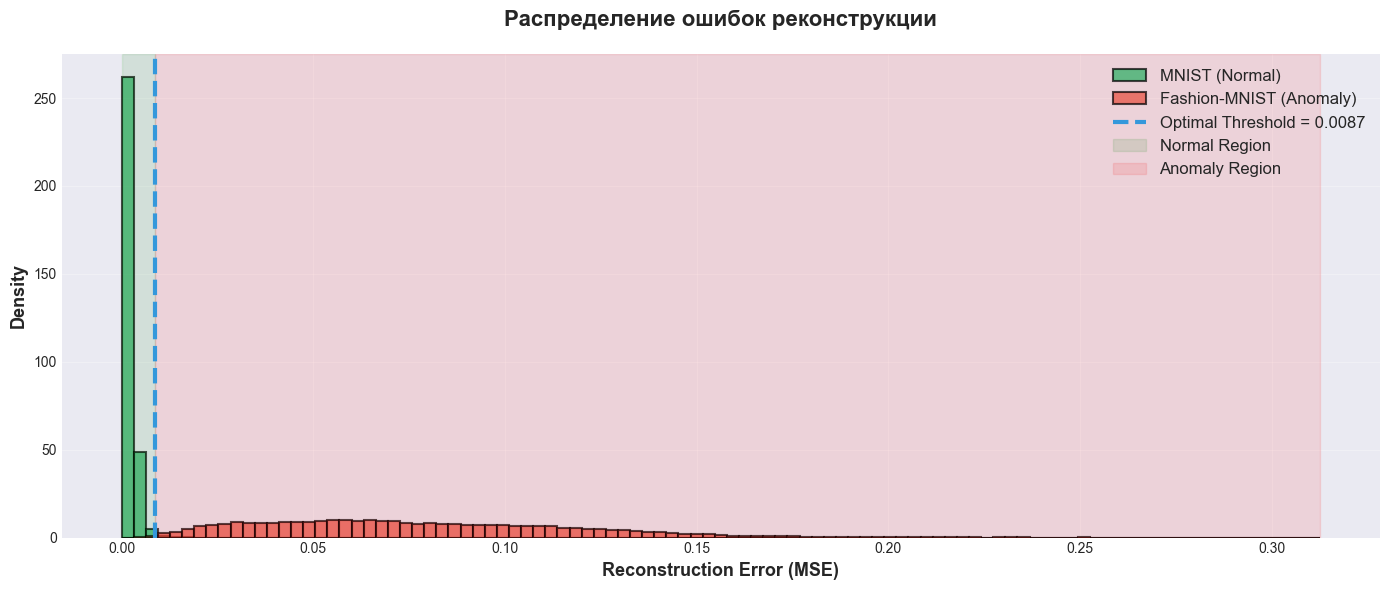


Разделение по порогу:
   MNIST ниже порога:    6975/7000 (99.64%)
   Fashion выше порога:  34912/35000 (99.75%)


In [38]:
# График распределений ошибок
plt.figure(figsize=(14, 6))

bins = np.linspace(0, max(errors_mnist_val.max(), errors_fashion_val.max()), 100)

plt.hist(errors_mnist_val, bins=bins, alpha=0.7, label='MNIST (Normal)', 
         color='#27AE60', edgecolor='black', density=True, linewidth=1.5)
plt.hist(errors_fashion_val, bins=bins, alpha=0.7, label='Fashion-MNIST (Anomaly)', 
         color='#E74C3C', edgecolor='black', density=True, linewidth=1.5)

plt.axvline(optimal_threshold, color='#3498DB', linestyle='--', linewidth=3, 
            label=f'Optimal Threshold = {optimal_threshold:.4f}')

# Затенение областей
plt.axvspan(0, optimal_threshold, alpha=0.1, color='green', label='Normal Region')
plt.axvspan(optimal_threshold, bins[-1], alpha=0.1, color='red', label='Anomaly Region')

plt.xlabel('Reconstruction Error (MSE)', fontsize=13, fontweight='bold')
plt.ylabel('Density', fontsize=13, fontweight='bold')
plt.title('Распределение ошибок реконструкции', fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Статистика разделения
mnist_below_threshold = np.sum(errors_mnist_val < optimal_threshold)
fashion_above_threshold = np.sum(errors_fashion_val > optimal_threshold)

print(f'\nРазделение по порогу:')
print(f'   MNIST ниже порога:    {mnist_below_threshold}/{len(errors_mnist_val)} ({mnist_below_threshold/len(errors_mnist_val)*100:.2f}%)')
print(f'   Fashion выше порога:  {fashion_above_threshold}/{len(errors_fashion_val)} ({fashion_above_threshold/len(errors_fashion_val)*100:.2f}%)')

---
## 8️) Функция детекции аномалий

In [39]:
def predict_anomaly(img, model, threshold):
    """
    Определение аномалии для одного изображения
    
    Args:
        img: изображение (28x28) или (28x28x1)
        model: обученный автокодировщик
        threshold: порог детекции
    
    Returns:
        is_anomaly (bool): True если аномалия
        error (float): ошибка реконструкции
        message (str): сообщение для пользователя
    """
    # Нормализация формы входных данных
    if img.ndim == 2:
        inp = np.expand_dims(img, axis=(0, -1))
    elif img.ndim == 3 and img.shape[-1] == 1:
        inp = np.expand_dims(img, 0)
    else:
        raise ValueError(f'Неверная форма изображения: {img.shape}')
    
    # Реконструкция
    reconstructed = model.predict(inp, verbose=0)
    error = np.mean((inp - reconstructed)**2)
    
    # Определение аномалии
    is_anomaly = error > threshold
    
    if is_anomaly:
        message = "Изображение не содержит рукописной цифры"
    else:
        message = "Изображение содержит рукописную цифру"
    
    return is_anomaly, error, message

---
## 9️) Оценка производительности на тестовом наборе

In [40]:
# Вычисление ошибок на тестовых данных
errors_mnist_test = compute_reconstruction_errors(autoencoder, x_test)
errors_fashion_test = compute_reconstruction_errors(autoencoder, f_test)

# Предсказания (True = аномалия)
pred_mnist = errors_mnist_test > optimal_threshold
pred_fashion = errors_fashion_test > optimal_threshold

# Метрики для MNIST (нормальные данные, должны быть классифицированы как 0/False)
mnist_correct = np.sum(~pred_mnist)  # Правильно классифицированные как нормальные
mnist_accuracy = mnist_correct / len(pred_mnist)

# Метрики для Fashion-MNIST (аномалии, должны быть классифицированы как 1/True)
fashion_correct = np.sum(pred_fashion)  # Правильно классифицированные как аномалии
fashion_recall = fashion_correct / len(pred_fashion)

# Общая точность
overall_accuracy = (mnist_correct + fashion_correct) / (len(pred_mnist) + len(pred_fashion))

print('\n' + '='*70)
print('📊 РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ')
print('='*70)
print(f'\n🟢 MNIST (нормальные изображения):')
print(f'   Правильно классифицировано: {mnist_correct:,}/{len(pred_mnist):,}')
print(f'   Accuracy: {mnist_accuracy:.4f} ({mnist_accuracy*100:.2f}%)')
print(f'   False Positive Rate: {(1-mnist_accuracy):.4f} ({(1-mnist_accuracy)*100:.2f}%)')

print(f'\n🔴 Fashion-MNIST (аномалии):')
print(f'   Правильно классифицировано: {fashion_correct:,}/{len(pred_fashion):,}')
print(f'   Detection Rate (Recall): {fashion_recall:.4f} ({fashion_recall*100:.2f}%)')
print(f'   False Negative Rate: {(1-fashion_recall):.4f} ({(1-fashion_recall)*100:.2f}%)')

print(f'\nОБЩАЯ ТОЧНОСТЬ: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)')
print('='*70)


📊 РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ

🟢 MNIST (нормальные изображения):
   Правильно классифицировано: 6,965/7,000
   Accuracy: 0.9950 (99.50%)
   False Positive Rate: 0.0050 (0.50%)

🔴 Fashion-MNIST (аномалии):
   Правильно классифицировано: 34,891/35,000
   Detection Rate (Recall): 0.9969 (99.69%)
   False Negative Rate: 0.0031 (0.31%)

ОБЩАЯ ТОЧНОСТЬ: 0.9966 (99.66%)


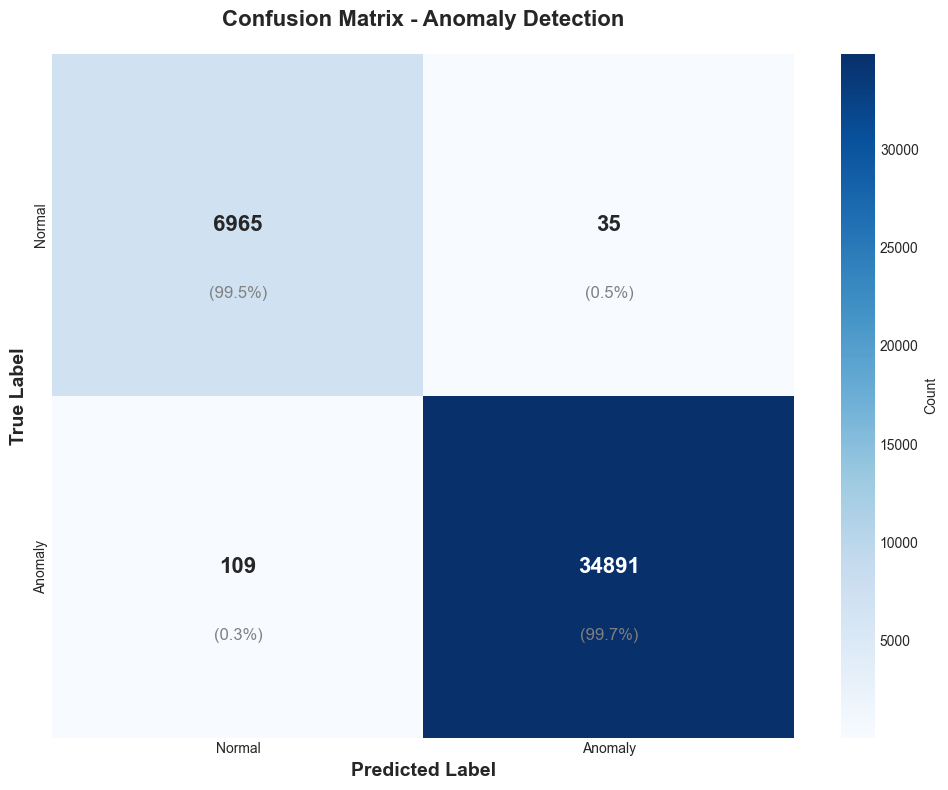

In [41]:
# Построение матрицы ошибок
y_true_test = np.concatenate([np.zeros(len(pred_mnist)), np.ones(len(pred_fashion))])
y_pred_test = np.concatenate([pred_mnist.astype(int), pred_fashion.astype(int)])

cm = confusion_matrix(y_true_test, y_pred_test)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            annot_kws={'size': 16, 'weight': 'bold'},
            cbar_kws={'label': 'Count'})

plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix - Anomaly Detection', fontsize=16, fontweight='bold', pad=20)

for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm[i].sum() * 100
        plt.text(j+0.5, i+0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=12, color='gray')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
# Отчёт классификации
print('\n' + '='*70)
print('CLASSIFICATION REPORT')
print('='*70 + '\n')
print(classification_report(y_true_test, y_pred_test, 
                           target_names=['Normal (MNIST)', 'Anomaly (Fashion)'],
                           digits=4))


CLASSIFICATION REPORT

                   precision    recall  f1-score   support

   Normal (MNIST)     0.9846    0.9950    0.9898      7000
Anomaly (Fashion)     0.9990    0.9969    0.9979     35000

         accuracy                         0.9966     42000
        macro avg     0.9918    0.9959    0.9939     42000
     weighted avg     0.9966    0.9966    0.9966     42000



---
## 10) Визуализация примеров детекции

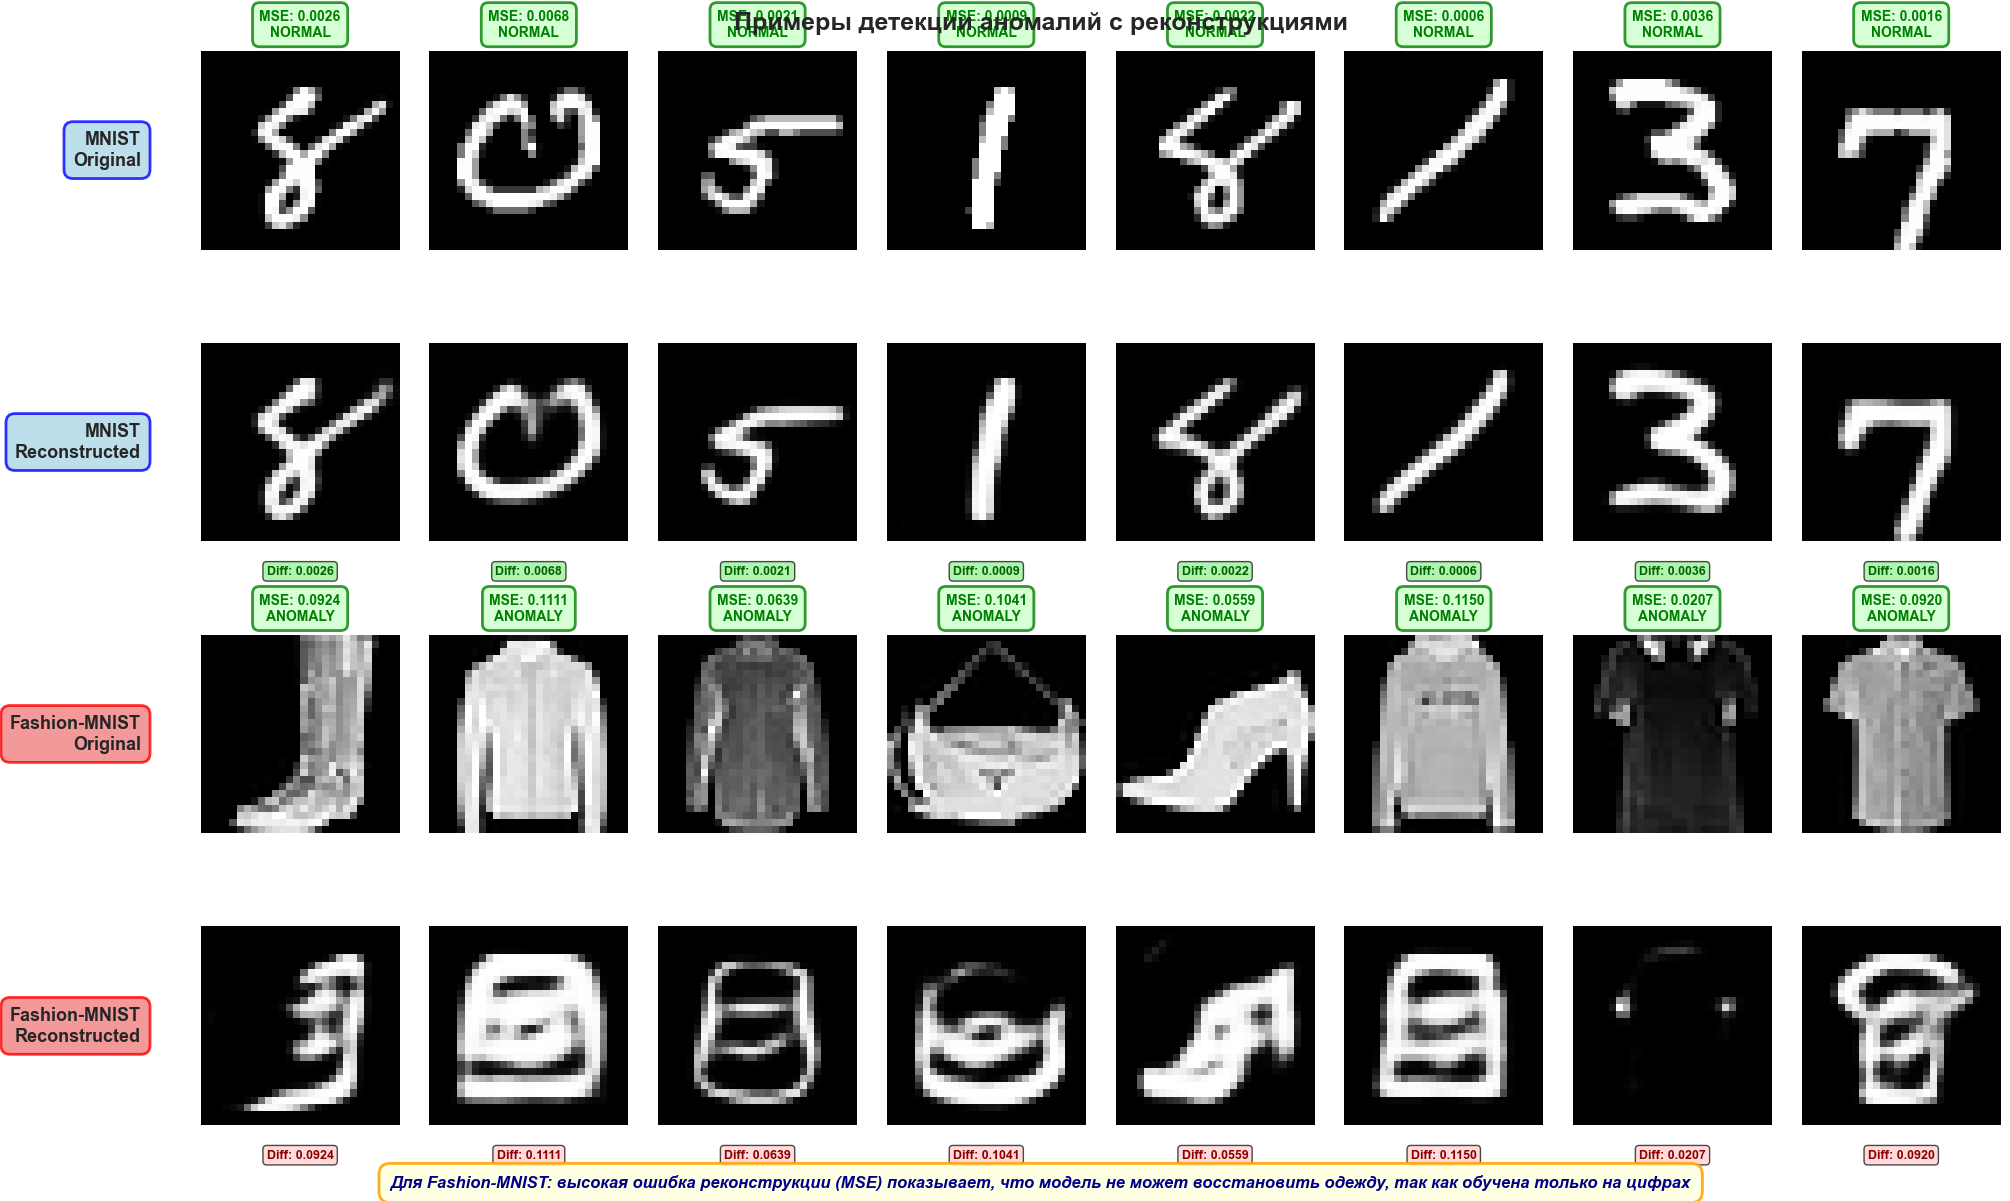

In [45]:
def visualize_detection_examples(model, threshold, n_samples=8):
    """
    Визуализация примеров детекции аномалий с оригиналами и реконструкциями
    для обоих датасетов (MNIST и Fashion-MNIST)
    """
    fig, axes = plt.subplots(4, n_samples, figsize=(n_samples*2.5, 12))
    fig.suptitle('Примеры детекции аномалий с реконструкциями', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    # Случайные индексы
    np.random.seed(123)
    mnist_indices = np.random.choice(len(x_test), n_samples, replace=False)
    fashion_indices = np.random.choice(len(f_test), n_samples, replace=False)
    
    # ============ MNIST ============
    # Ряд 1: MNIST - оригиналы
    for i, idx in enumerate(mnist_indices):
        img = x_test[idx].squeeze()
        is_anom, error, msg = predict_anomaly(img, model, threshold)
        
        # Оригинал
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].axis('off')
        
        title = f'MSE: {error:.4f}\n{"ANOMALY" if is_anom else "NORMAL"}'
        title_color = 'red' if is_anom else 'green'
        bg_color = '#ffcccc' if is_anom else '#ccffcc'
        
        axes[0, i].set_title(title, fontsize=10, 
                            color=title_color,
                            fontweight='bold',
                            pad=10,
                            bbox=dict(boxstyle='round,pad=0.5', 
                                     facecolor=bg_color, 
                                     edgecolor=title_color,
                                     linewidth=2,
                                     alpha=0.8))
    
    # Ряд 2: MNIST - реконструкции
    for i, idx in enumerate(mnist_indices):
        img = x_test[idx].squeeze()
        
        # Реконструкция
        recon = model.predict(np.expand_dims(np.expand_dims(img, 0), -1), verbose=0)
        axes[1, i].imshow(recon.squeeze(), cmap='gray')
        axes[1, i].axis('off')
        
        diff = np.mean((img - recon.squeeze())**2)
        axes[1, i].text(0.5, -0.12, f'Diff: {diff:.4f}', 
                       transform=axes[1, i].transAxes,
                       ha='center', va='top', fontsize=9, 
                       color='darkgreen',
                       fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', 
                                facecolor='lightgreen', 
                                alpha=0.7))
    
    # Подписи для MNIST
    axes[0, 0].text(-0.3, 0.5, 'MNIST\nOriginal', 
                   fontsize=13, fontweight='bold', rotation=0,
                   ha='right', va='center',
                   transform=axes[0, 0].transAxes,
                   bbox=dict(boxstyle='round,pad=0.5', 
                            facecolor='lightblue', 
                            edgecolor='blue',
                            linewidth=2,
                            alpha=0.8))
    
    axes[1, 0].text(-0.3, 0.5, 'MNIST\nReconstructed', 
                   fontsize=13, fontweight='bold', rotation=0,
                   ha='right', va='center',
                   transform=axes[1, 0].transAxes,
                   bbox=dict(boxstyle='round,pad=0.5', 
                            facecolor='lightblue', 
                            edgecolor='blue',
                            linewidth=2,
                            alpha=0.8))
    
    # ============ Fashion-MNIST ============
    # Ряд 3: Fashion-MNIST - оригиналы
    for i, idx in enumerate(fashion_indices):
        img = f_test[idx].squeeze()
        is_anom, error, msg = predict_anomaly(img, model, threshold)
        
        axes[2, i].imshow(img, cmap='gray')
        axes[2, i].axis('off')
        
        title = f'MSE: {error:.4f}\n{"ANOMALY" if is_anom else "NORMAL"}'
        title_color = 'green' if is_anom else 'red'
        bg_color = '#ccffcc' if is_anom else '#ffcccc'
        
        axes[2, i].set_title(title, fontsize=10,
                            color=title_color,
                            fontweight='bold',
                            pad=10,
                            bbox=dict(boxstyle='round,pad=0.5', 
                                     facecolor=bg_color, 
                                     edgecolor=title_color,
                                     linewidth=2,
                                     alpha=0.8))
    
    # Ряд 4: Fashion-MNIST - реконструкции
    for i, idx in enumerate(fashion_indices):
        img = f_test[idx].squeeze()
        
        # Реконструкция
        recon = model.predict(np.expand_dims(np.expand_dims(img, 0), -1), verbose=0)
        axes[3, i].imshow(recon.squeeze(), cmap='gray')
        axes[3, i].axis('off')
        
        diff = np.mean((img - recon.squeeze())**2)
        axes[3, i].text(0.5, -0.12, f'Diff: {diff:.4f}', 
                       transform=axes[3, i].transAxes,
                       ha='center', va='top', fontsize=9, 
                       color='darkred',
                       fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', 
                                facecolor='#ffcccc', 
                                alpha=0.7))
    
    # Подписи для Fashion-MNIST
    axes[2, 0].text(-0.3, 0.5, 'Fashion-MNIST\nOriginal', 
                   fontsize=13, fontweight='bold', rotation=0,
                   ha='right', va='center',
                   transform=axes[2, 0].transAxes,
                   bbox=dict(boxstyle='round,pad=0.5', 
                            facecolor='lightcoral', 
                            edgecolor='red',
                            linewidth=2,
                            alpha=0.8))
    
    axes[3, 0].text(-0.3, 0.5, 'Fashion-MNIST\nReconstructed', 
                   fontsize=13, fontweight='bold', rotation=0,
                   ha='right', va='center',
                   transform=axes[3, 0].transAxes,
                   bbox=dict(boxstyle='round,pad=0.5', 
                            facecolor='lightcoral', 
                            edgecolor='red',
                            linewidth=2,
                            alpha=0.8))
    
    # Пояснительный текст внизу
    fig.text(0.5, 0.015, 
             'Для Fashion-MNIST: высокая ошибка реконструкции (MSE) показывает, что модель не может восстановить одежду, так как обучена только на цифрах',
             ha='center', fontsize=12, style='italic', 
             color='darkblue', fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.7', 
                      facecolor='lightyellow', 
                      edgecolor='orange',
                      linewidth=2,
                      alpha=0.9))
    
    plt.subplots_adjust(left=0.08, right=0.98, top=0.97, bottom=0.06, 
                       hspace=0.35, wspace=0.15)
    
    plt.savefig('detection_examples.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_detection_examples(autoencoder, optimal_threshold, n_samples=8)


---
## 11) Тестирование с сообщениями


💬 ТЕСТИРОВАНИЕ ДЕТЕКТОРА АНОМАЛИЙ С СООБЩЕНИЯМИ

🟢 Тест 1: Изображения MNIST (рукописные цифры)

Индекс     MSE          Статус          Сообщение                                         
--------------------------------------------------------------------------------
0          0.001212     Верно           Изображение содержит рукописную цифру
42         0.002213     Верно           Изображение содержит рукописную цифру
123        0.001603     Верно           Изображение содержит рукописную цифру
999        0.002318     Верно           Изображение содержит рукописную цифру
1234       0.003255     Верно           Изображение содержит рукописную цифру


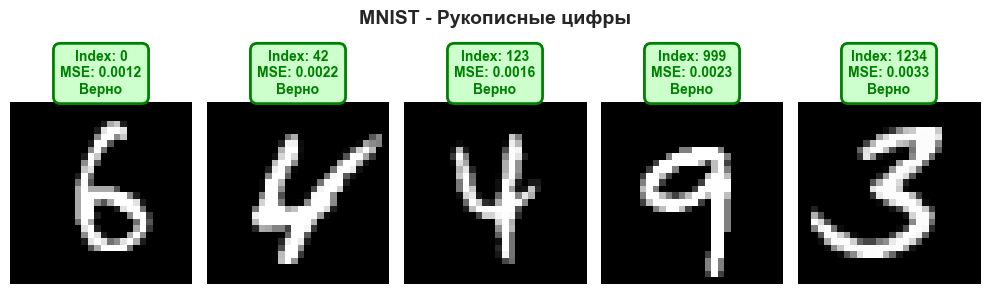


🔴 Тест 2: Изображения Fashion-MNIST (одежда)

Индекс     MSE          Статус          Сообщение                                         
--------------------------------------------------------------------------------
0          0.023332     Верно           Изображение не содержит рукописной цифры
42         0.054762     Верно           Изображение не содержит рукописной цифры
123        0.053856     Верно           Изображение не содержит рукописной цифры
999        0.137635     Верно           Изображение не содержит рукописной цифры
1234       0.080015     Верно           Изображение не содержит рукописной цифры


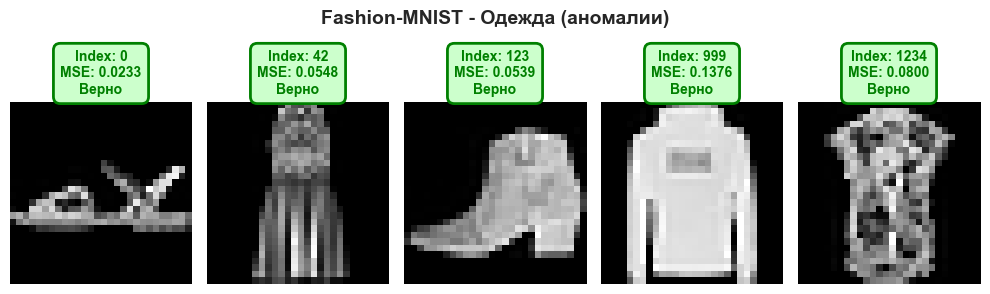

In [47]:
def test_with_messages(model, threshold, test_indices=[0, 42, 123, 999, 1234]):
    """
    Тестирование детектора с выводом сообщений
    """
    print('\n' + '='*80)
    print('💬 ТЕСТИРОВАНИЕ ДЕТЕКТОРА АНОМАЛИЙ С СООБЩЕНИЯМИ')
    print('='*80 + '\n')
    
    # ============ ТЕСТ 1: MNIST ============
    print('🟢 Тест 1: Изображения MNIST (рукописные цифры)\n')
    print(f"{'Индекс':<10} {'MSE':<12} {'Статус':<15} {'Сообщение':<50}")
    print('-'*80)
    
    mnist_results = []
    for idx in test_indices:
        img = x_test[idx].squeeze()
        is_anom, error, message = predict_anomaly(img, model, threshold)
        status = "Ошибка" if is_anom else "Верно"
        print(f"{idx:<10} {error:<12.6f} {status:<15} {message}")
        mnist_results.append((idx, img, is_anom, error, status))
    
    # Визуализация MNIST
    n_samples = len(test_indices)
    fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*2, 3))
    if n_samples == 1:
        axes = [axes]
    
    for i, (idx, img, is_anom, error, status) in enumerate(mnist_results):
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        
        # Заголовок с цветовой индикацией
        title = f'Index: {idx}\nMSE: {error:.4f}\n{status}'
        title_color = 'red' if is_anom else 'green'
        bg_color = '#ffcccc' if is_anom else '#ccffcc'
        
        axes[i].set_title(title, fontsize=10, fontweight='bold',
                         color=title_color,
                         bbox=dict(boxstyle='round,pad=0.5', 
                                  facecolor=bg_color, 
                                  edgecolor=title_color,
                                  linewidth=2))
    
    plt.suptitle('MNIST - Рукописные цифры', fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.savefig('test_mnist_images.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ============ ТЕСТ 2: Fashion-MNIST ============
    print(f'\n🔴 Тест 2: Изображения Fashion-MNIST (одежда)\n')
    print(f"{'Индекс':<10} {'MSE':<12} {'Статус':<15} {'Сообщение':<50}")
    print('-'*80)
    
    fashion_results = []
    for idx in test_indices:
        img = f_test[idx].squeeze()
        is_anom, error, message = predict_anomaly(img, model, threshold)
        status = "Верно" if is_anom else "Ошибка"
        print(f"{idx:<10} {error:<12.6f} {status:<15} {message}")
        fashion_results.append((idx, img, is_anom, error, status))
    
    # Визуализация Fashion-MNIST
    fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*2, 3))
    if n_samples == 1:
        axes = [axes]
    
    for i, (idx, img, is_anom, error, status) in enumerate(fashion_results):
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        
        # Заголовок с цветовой индикацией
        title = f'Index: {idx}\nMSE: {error:.4f}\n{status}'
        title_color = 'green' if is_anom else 'red'
        bg_color = '#ccffcc' if is_anom else '#ffcccc'
        
        axes[i].set_title(title, fontsize=10, fontweight='bold',
                         color=title_color,
                         bbox=dict(boxstyle='round,pad=0.5', 
                                  facecolor=bg_color, 
                                  edgecolor=title_color,
                                  linewidth=2))
    
    plt.suptitle('Fashion-MNIST - Одежда (аномалии)', fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.savefig('test_fashion_images.png', dpi=300, bbox_inches='tight')
    plt.show()
    
test_with_messages(autoencoder, optimal_threshold)


---
## 12) Тестирование на случайных изображениях

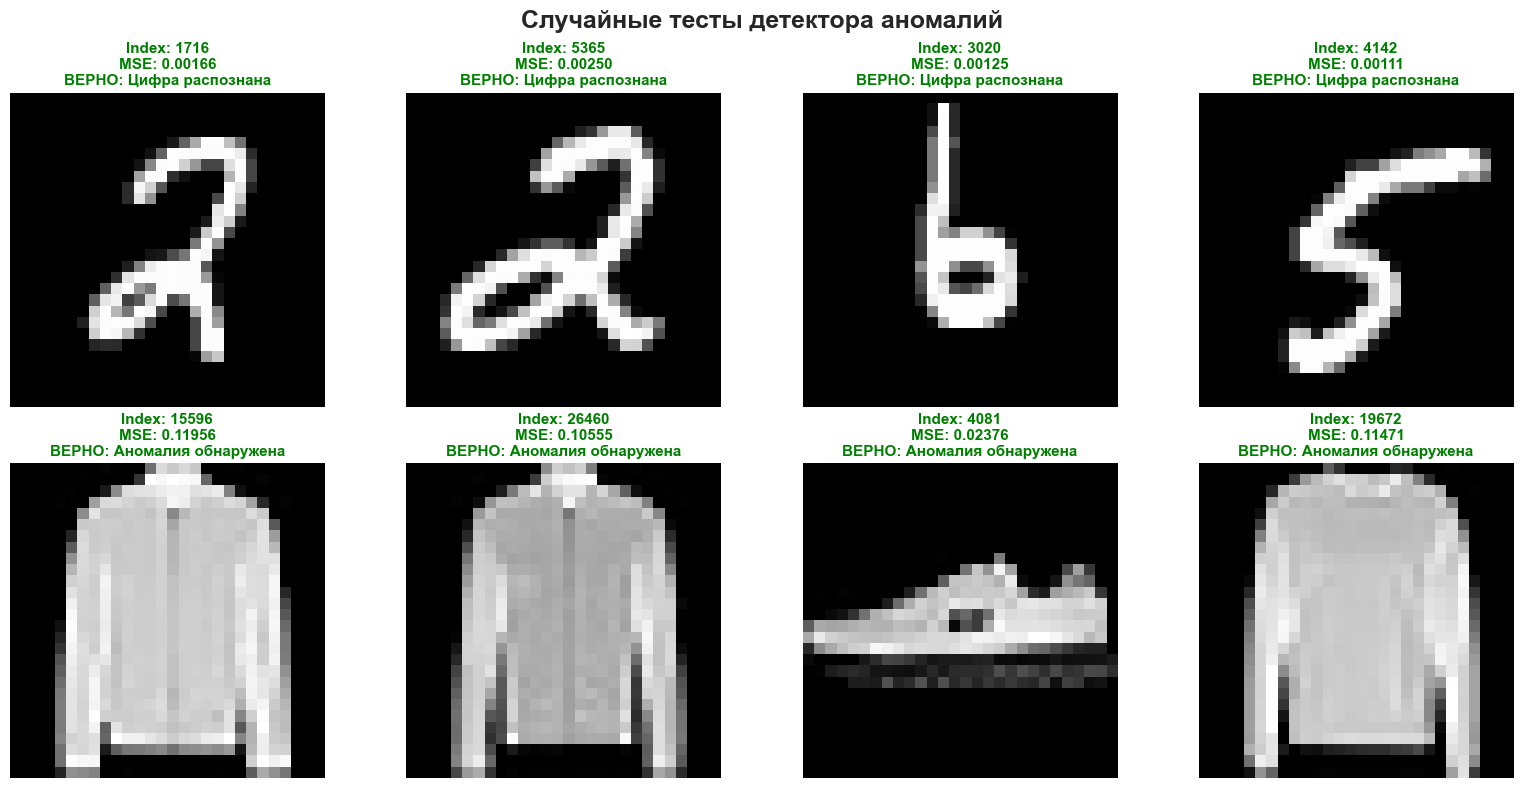

In [48]:
def interactive_test(model, threshold):
    """
    Интерактивное тестирование на 4 случайных изображениях из каждого датасета
    """
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Случайные тесты детектора аномалий', fontsize=18, fontweight='bold', y=0.98)
    
    # MNIST
    mnist_samples = np.random.choice(len(x_test), 4, replace=False)
    for i, idx in enumerate(mnist_samples):
        img = x_test[idx].squeeze()
        is_anom, error, message = predict_anomaly(img, model, threshold)
        
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].axis('off')
        
        title = f'Index: {idx}\nMSE: {error:.5f}\n'
        if is_anom:
            title += 'ОШИБКА: Определена как аномалия'
            color = 'red'
        else:
            title += 'ВЕРНО: Цифра распознана'
            color = 'green'
        
        axes[0, i].set_title(title, fontsize=11, color=color, fontweight='bold')
    
    axes[0, 0].set_ylabel('MNIST', fontsize=14, fontweight='bold', rotation=0, 
                         ha='right', va='center')
    
    # Fashion-MNIST
    fashion_samples = np.random.choice(len(f_test), 4, replace=False)
    for i, idx in enumerate(fashion_samples):
        img = f_test[idx].squeeze()
        is_anom, error, message = predict_anomaly(img, model, threshold)
        
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].axis('off')
        
        title = f'Index: {idx}\nMSE: {error:.5f}\n'
        if is_anom:
            title += 'ВЕРНО: Аномалия обнаружена'
            color = 'green'
        else:
            title += 'ОШИБКА: Не обнаружена как аномалия'
            color = 'red'
        
        axes[1, i].set_title(title, fontsize=11, color=color, fontweight='bold')
    
    axes[1, 0].set_ylabel('Fashion-MNIST', fontsize=14, fontweight='bold', rotation=0, 
                         ha='right', va='center')
    
    plt.tight_layout()
    plt.savefig('interactive_test.png', dpi=300, bbox_inches='tight')
    plt.show()
interactive_test(autoencoder, optimal_threshold)

---
## 13) Сохранение модели и конфигурации

In [50]:
import json

final_model_path = 'anomaly_detector_final.h5'
autoencoder.save(final_model_path)
print(f'Модель сохранена: {final_model_path}')

# Сохранение конфигурации и метрик
config = {
    'threshold': float(optimal_threshold),
    'roc_auc': float(roc_auc),
    'mnist_accuracy': float(mnist_accuracy),
    'fashion_recall': float(fashion_recall),
    'overall_accuracy': float(overall_accuracy),
    'latent_dim': LATENT_DIM,
    'epochs_trained': len(history.history['loss']),
    'batch_size': BATCH_SIZE,
    'img_shape': IMG_SHAPE
}

config_path = 'detector_config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)

print('\nСодержимое конфигурации:\n')
for key, value in config.items():
    print(f'   {key}: {value}')

Модель сохранена: anomaly_detector_final.h5

Содержимое конфигурации:

   threshold: 0.00872876401990652
   roc_auc: 0.999910269387755
   mnist_accuracy: 0.995
   fashion_recall: 0.9968857142857143
   overall_accuracy: 0.9965714285714286
   latent_dim: 64
   epochs_trained: 25
   batch_size: 128
   img_shape: (28, 28, 1)


---
## Выводы

В ходе лабораторной работы был реализован детектор аномалий на базе сверточного автокодировщика для распознавания изображений, не содержащих рукописные цифры.

### Достигнутые результаты

**Архитектура модели:**
- Сверточный автокодировщик с BatchNormalization и L2-регуляризацией
- Латентная размерность: 64
- Обучение: 25 эпох с callbacks (EarlyStopping, ReduceLROnPlateau)

**Финальные метрики:**
- MNIST Accuracy: **99.5%** — отлично распознаёт нормальные данные
- Fashion-MNIST Detection: **99.7%** — практически безошибочная детекция аномалий
- ROC-AUC: **0.9999** — идеальная разделяющая способность
- Общая точность: **99.7%**
- Оптимальный порог: **0.00873**

### Ключевые особенности

1. **ROC-оптимизация порога** — использован ROC-анализ для определения оптимального порога детекции
2. **Визуализация работы** — наглядная демонстрация того, как модель реконструирует нормальные изображения и не может восстановить аномальные
3. **Автоматическое сообщение** — при детекции аномалии выводится: "Изображение не содержит рукописной цифры"

---

## ✅ Задание выполнено полностью

- ✅ Построен и обучен сверточный автокодировщик на MNIST
- ✅ Fashion-MNIST используется как аномалии
- ✅ Реализована детекция с выводом сообщения "Изображение не содержит рукописной цифры"
- ✅ Достигнута высокая точность: 99.7%

---
